# Masked Autoencoder for Distribution Estimation (MADE)

**Paper: ** https://arxiv.org/pdf/1502.03509.pdf

**Author: ** Jhosimar George Arias Figueroa

## Import Libraries

In [0]:
import tensorflow as tf
import keras
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Load MNIST Dataset

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
img_rows, img_cols, img_chns = X_train.shape[1], X_train.shape[2], 1
X_train = np.round(X_train.reshape(X_train.shape[0], img_rows * img_cols) / 255.)
X_test = np.round(X_test.reshape(X_test.shape[0], img_rows * img_cols) / 255.)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

((60000, 784), (60000,))
((10000, 784), (10000,))


### Create Validation Dataset

In [0]:
def partition_dataset(X_train, y_train, proportion=0.8):
  # hold out split - 80% training and 20% validation
  indices = np.random.permutation(X_train.shape[0])
  train_size = int(proportion * X_train.shape[0])
  train_indices, val_indices = indices[:train_size], indices[train_size:]
  train_data, train_labels = X_train[train_indices], y_train[train_indices]
  validation_data, validation_labels = X_train[val_indices], y_train[val_indices]
  return train_data, train_labels, validation_data, validation_labels

X_train, y_train, X_val, y_val = partition_dataset(X_train, y_train, 0.8)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

((48000, 784), (48000,))
((12000, 784), (12000,))


### Display Dataset

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


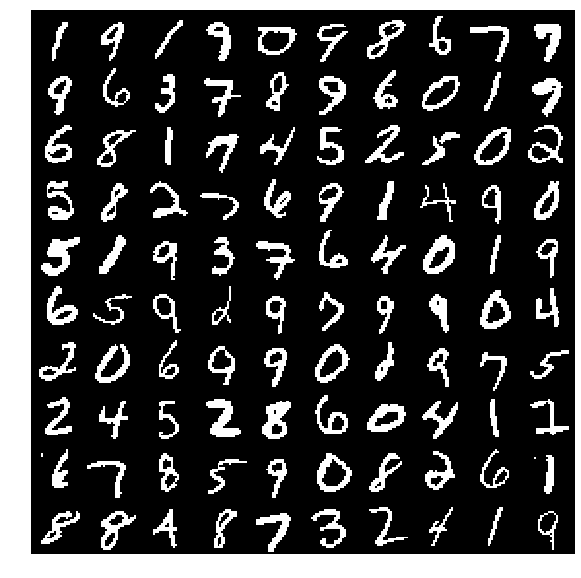

In [0]:
def display_dataset(X, H, W, n=10):
  grid = np.zeros((H * n, W * n))
  for i in range(n):
    for j in range(n):
      index = np.random.randint(X.shape[0])
      sample = X[index].reshape(H, W)
      grid[i*H:i*H+H,j*W:j*W+W] = sample
  
  plt.figure(figsize=(n, n))
  plt.imshow(grid, cmap=plt.get_cmap('gray'))
  plt.grid('off')
  plt.axis('off')
  plt.show()

display_dataset(X_train, img_rows, img_cols)

## MADE Model

In [0]:
class MADE:

  def __init__(self, **params):
    self.sess = tf.Session()
    self.num_epochs = params.get('num_epochs', 100)
    self.batch_size = params.get('batch_size', 32)
    self.learning_rate = params.get('learning_rate', 0.001)
    self.verbose = params.get('verbose', 1)
    self.hidden_sizes = params.get('hidden_sizes', [])
    self.natural_ordering = params.get('natural_ordering', True)
    self.initializer = tf.contrib.layers.xavier_initializer(uniform=False)


  def build_weight(self, shape, use_bias=True):
    """Weight initialization
    
    Args:
        shape: (array) weight shape ,e.g., (rows,cols)
        use_bias: (bool) whether to use bias or not
        
    Returns:
        W,b: (array) initialized weight and bias
    """
    # initialize the weights
    W = tf.Variable(self.initializer(shape), dtype=tf.float32, name='weight')
    # initialize bias if required
    if use_bias == True:
      b = tf.Variable(tf.constant(0.1, shape=[shape[-1]]), name='bias')
    else:
      b = None
    # initialized weight and bias  
    return W, b


  def build_weight_mask(self, shape, prev_indices, output_size, is_output=True):
    """Weight mask generation
    
    Args:
        shape: (array) weight shape ,e.g., (rows,cols)
        prev_indices: (array) indices values of previous layer
        output_size: (int) output size
        is_output: (bool) whether we are in the output layer or not
        
    Returns:
        mask: (array) generated weight mask
        indices: (array) indices of the current layer
    """
    if is_output:
      # input and ouput have same shape
      indices = self.initial_indices
    else:
      # generate random indices for current weight
      indices = np.random.randint(prev_indices.min(), output_size - 1, size=shape[-1])
    # create mask based on current and previous indices
    if is_output == False:
      mask = prev_indices[:,None] <= indices[None,:]
    else:
      mask = prev_indices[:,None] < indices[None,:]
      
    # mask matrix and current indices  
    return tf.constant(mask, dtype='float32', shape=shape), indices
  
  
  def initialize_weights(self, input_size, output_size):
    """Network weights initialization
    
    Args:
        input_size: (int) input size
        output_size: (int) output size
        
    Returns:
        None but all the weights will be saved for later use.
    """
    # shape of first layer
    shape = (input_size, self.hidden_sizes[0])
    
    # create indices for the different variables
    prev_indices = np.arange(input_size) if self.natural_ordering else np.random.permutation(input_size)
    self.initial_indices = prev_indices.copy()
    
    # network weights
    self.W_hidden, self.b_hidden = [], []
    self.W_mask_hidden = []
    
    # create weights of hidden layers
    for i in range(len(self.hidden_sizes)):
      # create random weights and bias
      W, b = self.build_weight(shape)
      # create mask according to the indices
      mask, prev_indices = self.build_weight_mask(shape, prev_indices, output_size, False)
      
      self.W_hidden.append(W)
      self.W_mask_hidden.append(mask)
      self.b_hidden.append(b)
      
      if i + 1 < len(self.hidden_sizes):
        # update the shape of the next layer
        shape = (self.hidden_sizes[i], self.hidden_sizes[i + 1])
   
    
    # create weights of last layer
    shape = (self.hidden_sizes[-1], output_size)
    # create random weights and bias
    W, b = self.build_weight(shape)
    # create mask according to the indices
    mask, _ = self.build_weight_mask(shape, prev_indices, output_size, True)
    
    self.W_output, self.b_output = W, b
    self.W_mask_output = mask

    # create weights of connection between input and output
    shape = (input_size, output_size)
    # create random weights and bias
    W, _ = self.build_weight(shape, False)
    # create mask according to the indices
    mask, _ = self.build_weight_mask(shape, self.initial_indices, output_size, True)
    
    self.W_in_out = W
    self.W_mask_in_out = mask
    
  
  def build_network(self, input_data, input_size, output_size):
    """Neural network definition
    
    Args:
        input_data: (array) array with the input data (variables)
        input_size: (int) input size
        output_size: (int) output size
        
    Returns:
        output: (array) array with the output data (conditional probs)
    """
    output = input_data
    
    # create hidden layers
    for i in range(len(self.hidden_sizes)):
      W, b = self.W_hidden[i], self.b_hidden[i]
      W_mask = self.W_mask_hidden[i]
      # use the mask over the weights
      W_masked = (W * W_mask)
      # use the new weights in the network
      output = tf.nn.relu(tf.matmul(output, W_masked) + b)
    
    # create last layer
    W, b = self.W_output, self.b_output
    W_mask = self.W_mask_output
    # use the mask over the weights
    W_masked = (W * W_mask)
    # use the new weights in the network
    # bias + (V dot M_v)h(x)
    output = tf.matmul(output, W_masked) + b
    
    # create connection between input and output    
    W = self.W_in_out
    W_mask = self.W_mask_in_out
    # use the mask over the weights
    W_masked = (W * W_mask)
    # out_act(bias + (V dot M_v)h(x) + (A dot M_v)x) 
    output = tf.nn.sigmoid(output + tf.matmul(input_data, W_masked))
    
    return output
 

  def validate(self, X_val, batch_size= -1):
    """Validate dataset after training
    
    Args:
        X_val: (array) array with validation data
        batch_size: (int) batch size
        
    Returns:
        avg_loss: (float) average loss
    """
    if batch_size == -1:
      batch_size = self.batch_size
    num_elements = X_val.shape[0]
    num_batches = num_elements // batch_size
    avg_val_loss = 0.0
    for i in range(num_batches):
      val_batch = X_val[i*batch_size:i*batch_size+batch_size]
      #print val_batch.shape
      _loss = self.sess.run(self.loss, feed_dict={self.input_data:val_batch})
      #_loss = self.sess.run(self.val_model['loss'], feed_dict={self.input_data:val_batch})
      avg_val_loss += _loss
    avg_val_loss /= num_batches
    return avg_val_loss
  
  
  def binary_cross_entropy(self, p, q):    
    """Binary Cross Entropy between the true and predicted outputs
       loss = (1/n) * -Σ(real*log(predicted) + (1 - real)*log(1 - predicted))
    Args:
        p: (array) array containing the true labels
        q: (array) array containing the predicted labels

    Returns:
        output: (array/float) mean of all the sample losses
    """
    loss = -tf.reduce_sum(p * tf.log(q + 1e-8) + (1 - p) * tf.log(1 - q  + 1e-8), axis=1)
    return tf.reduce_mean(loss)
    

  def train(self, X_train, X_val):
    """Train the model
    Args:
        X_train: (array) array containing the training data
        X_val: (array) array containing the validation data

    Returns:
        None but different values will be saved during the training process
        for instance: the history of train/val loss
    """
    self.input_data = tf.placeholder(tf.float32, shape=None)
    
    input_size = X_train.shape[-1]
    output_size = X_train.shape[-1]
    self.input_size = input_size
    
    # initialize weights
    self.initialize_weights(input_size, output_size)

    # build network
    self.output = self.build_network(self.input_data, input_size, output_size)
    # loss function
    self.loss = self.binary_cross_entropy(self.input_data, self.output)
    # optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
    train_op = optimizer.minimize(self.loss)

    # initialize variables
    init_op = tf.global_variables_initializer()
    
    # set batch variables
    batch_size = self.batch_size
    num_train_elements = X_train.shape[0]
    num_batches = num_train_elements // batch_size

    history_train = []
    history_val = []

    self.sess.run(init_op)
    # iterate over the specified number of epochs
    for e in range(self.num_epochs):    
      #if e > 0 and e % 10 == 0:
      #  learning_rate = learning_rate * 0.5

      # training phase
      avg_train_loss = 0.0
      for i in range(num_batches):
        train_batch = X_train[i*batch_size:i*batch_size+batch_size]
        _loss, _ = self.sess.run([self.loss, train_op],
                                    feed_dict={self.input_data:train_batch})
        avg_train_loss += _loss
      avg_train_loss /= num_batches
      # save results
      history_train.append(avg_train_loss)

      # validation phase
      avg_val_loss = self.validate(X_val)
      # save results      
      history_val.append(avg_val_loss)

      if (e + 1) % self.verbose == 0:
        print("(%d/%d) training loss: %lf, validation loss: %lf" % (e + 1, self.num_epochs, avg_train_loss, avg_val_loss))

    self.history_val = history_val
    self.history_train = history_train

  
  def test(self, X_test, batch_size=-1):
    """Test dataset after training
    
    Args:
        X_test: (array) array with test data
        batch_size: (int) batch size
        
    Returns:
        avg_loss: (float) average loss
    """
    return self.validate(X_test, batch_size)
  
  
  def image_generation(self, num_samples=10):
    """Random image generation
    
    Args:
        num_samples: (int) number of random images to generate
        
    Returns:
        x_sample: (array) generated images
    """
    # initialize random input data
    x_sample = np.random.rand(num_samples, self.input_size)
    # for each variable perform a forward call
    # then sample from a bernoulli distribution
    # set the sampled value in its corresponding index in random_input
    # repeat the process
    for i in range(self.input_size):
      output = self.sess.run(self.output, feed_dict={self.input_data:x_sample})
      indices = self.initial_indices
      current_variable = np.argmax(indices == i)
      
      # sampling from bernoulli distribution
      p = np.random.rand(num_samples)
      x_sample[:,current_variable] = (output[:,current_variable] > p).astype(float)
      
    return x_sample

## Train Model

Model initialization with different parameters:

In [0]:
model = MADE(num_epochs=20, 
             batch_size=32, 
             learning_rate= 0.0005, 
             hidden_sizes=[700, 700],
             natural_ordering = True,
             verbose = 1)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Training model with validation data:

In [0]:
model.train(X_train, X_val)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
(1/20) training loss: 150.258830, validation loss: 112.311130
(2/20) training loss: 100.775041, validation loss: 93.510121
(3/20) training loss: 87.854169, validation loss: 84.995914
(4/20) training loss: 81.147974, validation loss: 80.210748
(5/20) training loss: 77.031632, validation loss: 77.199234
(6/20) training loss: 74.238993, validation loss: 75.146791
(7/20) training loss: 72.208440, validation loss: 73.701270
(8/20) training loss: 70.659326, validation loss: 72.629016
(9/20) training loss: 69.432258, validation loss: 71.817669
(10/20) training loss: 68.433760, validation loss: 71.201185
(11/20) training loss: 67.601587, validation loss: 70.712034
(12/20) training loss: 66.894781, validation loss: 70.331356
(13/20) training loss: 66.284686, validation loss: 70.028711
(14/20) training loss: 65.749856, validation loss: 69.791601
(15/20) training loss: 65.277057

## Test Model

Test the trained model with the test dataset and obtain the loss value

In [0]:
test_loss = model.test(X_test)

print("Test Loss: %lf" % test_loss)

Test Loss: 68.329757


## Image Generation

In [0]:
generated = model.image_generation(100)

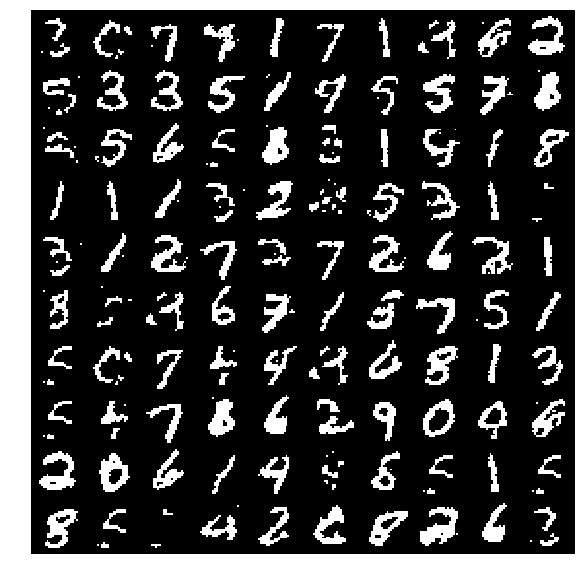

In [0]:
display_dataset(generated, img_rows, img_cols, 10)